# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions of a single installation.

As a starting point, we assume that the installation identifier is known. The most easy way to find the identifier is going to www.EUETS.INFO/installations and use the search field.

Specifically, we consider the Drax Power Station with installation identifier GB_381. To analyze another installation, simply change the assignment determining the installation identifier (but the text most likely no longer fits;).

The analysis takes place in three steps:
1. Use the installation identifier to get the installation object.
2. The installation object provides methods to obtain compliance and surrendering details as well as associated accounts
3. Account objects provide methods to assess related transactions.

In [1]:
id_inst = "GB_381"

# Packages and options

In [2]:
from eutl_orm import DataAccessLayer    # data access layer to access the database
from eutl_orm import Installation       # EUETS Installation object
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Database connection settings

In [3]:
connectionSettings = dict(
    user="eutlAdmin", 
    host="localhost", 
    db="eutl_orm", 
    passw="1234",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [4]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get installation

Given the installation id, use the session to query the installation:

In [5]:
inst = session.query(Installation).get(id_inst)
print(inst.id + ": " + inst.name)
print(inst.address)

GB_381: Drax Power Station
DRAX POWER LIMITED,
DRAX POWER STATION, PO BOX 3
YO8 8PQ SELBY, NORTH YORKSHIRE
United Kingdom


# Analyze compliance

Compliance is a property of the installation. For convenience, .get_compliance() provides the compliance as pandas DataFrame.

In [6]:
inst.compliance
df_compliance = inst.get_compliance()
df_compliance.head(2)

,allocated10c,allocatedNewEntrance,compliance_id,euetsPhase,installation_id,surrenderedCummulative,verifiedUpdated,verified,allocatedTotal,allocatedFree,year,surrendered,verifiedCummulative,compliance
0,0.0,0.0,A,2005-2007,GB_381,20771624.0,False,20771624.0,14554187.0,14554187.0,2005,20771624.0,20771624.0,The number of allowances and ERUs/CERs surrend...
1,0.0,0.0,A,2005-2007,GB_381,43536471.0,False,22764847.0,14554187.0,14554187.0,2006,22764847.0,43536471.0,The number of allowances and ERUs/CERs surrend...


To get a first impression, plot compliance, i.e., allocated and surrendered allowances and verified emissions over time:

<AxesSubplot:xlabel='year', ylabel='Million tCO$_2$'>

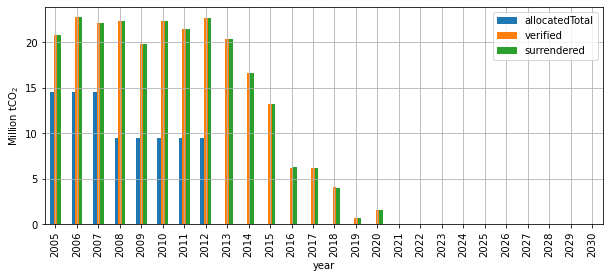

In [7]:
df_compliance[["year", "allocatedTotal", "verified", "surrendered"]]\
    .set_index("year").div(1000000)\
    .plot(kind="bar", figsize=(10,4), ylabel=r"Million tCO$_2$", grid=True)

The plot provides three main insights: First, in all years, verified emissions equal surrendered allowances, i.e., the installation was always compliant. Second, emissions remained rather constant between 2005 and 2012 although showing some annual variations. From 2012 onwards, emissions show a strongly decreasing trend. Third, in the first (second) EUETS period, the installation received about 15 (9) million allowances for free but received no free allocation after 2012. Irrespective of free allocation, the installation was in need to acquire additional allowances, i.e., verified emissions always exceeded free allocation.

# Surrendering

The installation was in need to acquire additional allowances to be compliant with the EUETS. This offers the question, which allowances have been surrendered. For the first two periods (2005-2007, 2008-2012) the EUTL reports the type of allowances surrendered (e.g., EUA, CER, ERU) as well as the country in which the surrendered certificate has been created. 

Technically, surrendering unit details are also accessible through the installation object (property: surrendering) and the method get_surrendering() provides a Pandas dataframe:

In [8]:
inst.get_surrendering().head(2)

,originatingRegistry_id,project_id,unitType_id,installation_id,amount,year,unitType
0,AT,NaN,EUA2005,GB_381,14000,2005,Allowance issued for the 2005-2007 period and ...
1,BE,NaN,EUA2005,GB_381,600500,2005,Allowance issued for the 2005-2007 period and ...


For periods prior to 2013 we observe the country of origin for surrendered units: 

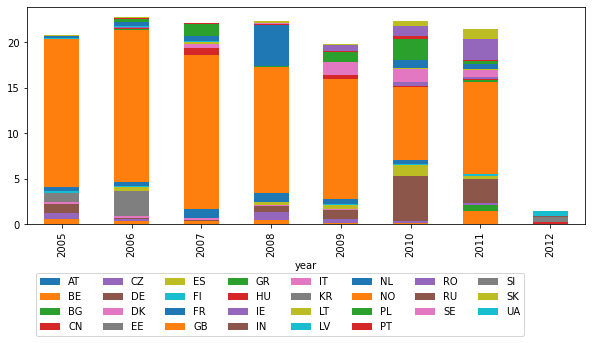

In [9]:
ax = inst.get_surrendering()\
        [["year", "originatingRegistry_id", "amount"]]\
        .pivot_table("amount", "year", "originatingRegistry_id")\
        .div(1000000)\
        .plot(kind="bar", stacked=True,  figsize=(10,4),)
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=8)

We observe a rather diverse picture of allowances origins. Naturally, the largest share of allowances was created in the UK as the installation is located in the UK. In later years, we observe the usage of international credits created in Russia. 

For the remainder of this notebook, we concentrate on the first year of the EUETS, i.e., surrendering in 2005.

In [10]:
df_surrender = inst.get_surrendering()
df_surrender = df_surrender[df_surrender.year == 2005]\
                    .drop(["year", "unitType_id", "project_id", "installation_id"], axis=1)\
                    .sort_values("amount", ascending=False)
df_surrender.amount = df_surrender.amount/1000000
df_surrender

,originatingRegistry_id,amount,unitType
9,GB,16.257826,Allowance issued for the 2005-2007 period and ...
3,DE,0.983190,Allowance issued for the 2005-2007 period and ...
5,EE,0.895000,Allowance issued for the 2005-2007 period and ...
2,CZ,0.675008,Allowance issued for the 2005-2007 period and ...
1,BE,0.600500,Allowance issued for the 2005-2007 period and ...
8,FR,0.485457,Allowance issued for the 2005-2007 period and ...
7,FI,0.237833,Allowance issued for the 2005-2007 period and ...
4,DK,0.224255,Allowance issued for the 2005-2007 period and ...
12,NL,0.205720,Allowance issued for the 2005-2007 period and ...
14,SK,0.086869,Allowance issued for the 2005-2007 period and ...


In 2005, only allowanced for the first period existed. The installation show a rather divers pattern of allowance origins implying that the associated account has to be involved in quite some transactions in the first year of trading.

# Accounts

Our installation shows a surprising variety of allowances used for surrendering. This offers the question how did they acquire these allowances? To find an answer to this this questions, we need to examine the transaction behavior of related <i>Accounts</i>.

The EUETS implements emissions trading. Industrial plants regulated are called <i>Installations</i>. Each installation has to be related to an accounts. These accounts might (and are likely to) change over time but at each instance in time an installation is represented by an account. Accounts are the backbone of the trading system, i.e., allowances are transferred between accounts not between installations. Accounts related to installations are called operator holding accounts. As transfers of allowances take place at the account level, we need to find out which accounts represent our installation.

Technically, related accounts are again implemented as property on the installation object (property: accounts). Accounts related to installations are called operator holding accounts (oha):

In [11]:
ohas = inst.accounts
ohas

[<Account(24147, 'GB Drax Power Station', 'GB', '100-7')>,
 <Account(22790, 'GB Operator Account', 'GB', '120-0')>]

There are two different accounts. 120-0 denotes former operator holding accounts whereas 100-7 denotes the operating holding account. This account structure is common for installations that have been regulated under the EUETS already before 2013. Due to the change in the EUTL, all installation had to convert their account from 120-0 to 100-7 accounts. Consequently, our 2005 analysis has to focus in the 120-0 account with the meaningful name "Operator Account".

## Getting transactions

Transactions are provided as property on the respective account (property: transactions). To separate transaction by whether the selected account is acquiring or transferring allowances, separate transactions exist (acquiringTransactions, transferringTransactions). get_transactions() provides again a Pandas dataframe with transaction by the respective account.

In [12]:
df_trans = ohas[1].get_transactions()
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3666 entries, 2005-05-24 17:45:16.876000 to 2012-12-07 12:54:15.072000
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               3666 non-null   int64  
 1   transferringAccount_id           3666 non-null   int64  
 2   project_id                       123 non-null    float64
 3   acquiringAccount_id              3666 non-null   int64  
 4   transactionTypeSupplementary_id  3666 non-null   int64  
 5   transactionID                    3666 non-null   object 
 6   amount                           3666 non-null   int64  
 7   unitType_id                      3666 non-null   object 
 8   transactionTypeMain_id           3666 non-null   int64  
 9   unitType                         3666 non-null   object 
 10  transactionTypeMain              3666 non-null   object 
 11  transactionTypeSupplementary    

Given that we look at an former operator holding accounts, we observe transactions between 2005 and 2012. Overall we observe over 10000 entries in the transaction data. However, that does not mean that the transaction was involved in 10000 transactions. If a transaction involves different unit types or units from different origins, this is reported as a row in the transaction data. To see the number of transactions carried out, we count the number of transactionIDs as provided by the EUTL: 

In [13]:
print("Number of transactions: %d" % len(df_trans["transactionID"].unique()))

Number of transactions: 206


So only 206 transactions have been carried out. Before continuing to analyze the first year of transaction activities, we show how to calculate allowance holdings over time.

## Allowances holdings

The dataframe contains a column "direction" which equals 1 if the account is acquiring and -1 if the account is transferring allowances. The column "amount_directed" contains to the amount of each transaction multiplied by the direction. We can use it plot transfers over time and also the cumulative allowance holding:

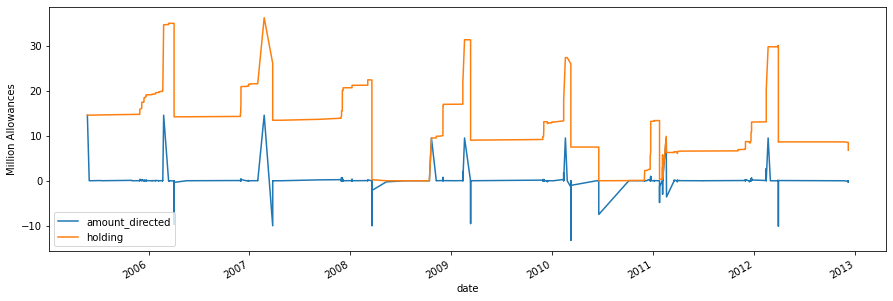

In [14]:
df_ = df_trans[["amount_directed"]]/1000000
df_["holding"] = df_.amount_directed.cumsum()
ax = df_.plot( figsize=(15,5), ylabel="Million Allowances")

We observe a rather typical pattern. End of February, the account receives a large amount of allowances (blue line). This is primary allocation of allowances. It is followed by a large negative transfer which marks surrendering of allowances. In between we observe further transactions which might be market transaction, transactions within the company, etc. Allowance holding naturally follows transactions. Surprisingly, after the last transaction observed, allowance holding is still positive.

## Transactions

Lets finally take a closer look at transactions until the first surrendering of allowances that took place beginning of April 2006. We do not aim to track the origin of allowances and, thus, aggregate data to transactions that took place

In [15]:
df_trans_2005 = df_trans[:"2006/04/05"]
df_trans_2005.reset_index().groupby(
    ["date", "transactionID", "transactionTypeMain", "transactionTypeSupplementary",
     "transferringAccountName", "transferringAccountType",
     "acquiringAccountName", "acquiringAccountType"], as_index=False)\
    .amount_directed.sum().set_index("date").sort_index()

,transactionID,transactionTypeMain,transactionTypeSupplementary,transferringAccountName,transferringAccountType,acquiringAccountName,acquiringAccountType,amount_directed
date,,,,,,,,
2005-05-24 17:45:16.876,GB349,Internal - Internal transfer of unit/supplemen...,Allowance allocation,GB 2005 NAP,Party Holding Account,GB Operator Account,Former Operator Holding Account,14554187
2005-05-31 11:59:00.035,DK848,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,5000
2005-07-15 14:47:59.151,DK907,External - External transfer of unit between r...,External transfer (2005-2007),DK EBL Trading DK:DK388,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,10000
2005-11-01 18:14:54.387,DK1038,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,100000
2005-11-30 14:17:59.789,DK1193,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,160000
2005-12-14 15:17:47.575,DK1284,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,60000
2005-12-20 16:03:28.308,DK1333,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,10000
2006-01-13 15:51:56.981,DK1417,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,135000
2006-02-09 16:39:09.170,DK1571,External - External transfer of unit between r...,External transfer (2005-2007),DK Shell Trading International Limited (STIL):...,Person Account in National Registry,GB Operator Account,Former Operator Holding Account,20000


In the very first transactions, the operator account received allowances from the UK regulator (allocation). Then in a series of transactions, the account acquired additional allowances mainly from an account seeming to be owned by Shell. You can search by the account name on EUETS.INFO showing that albeit the account is registered in Denmark, the holder is located in the UK, more specifically in London. On 2006/02/24 we observe the 2006 allocation of allowances followed by additional acquiring from Barclays and again Shell. Finally, allowances covering 2005 emissions are transfer to the UK regulator in three transactions on 2006/04/03.

# Conclusions

This notebook shows how the EUTL database provided by EUETS.INFO can be used to analyze compliance and transaction behavior of a single installation. The analysis takes place in three steps:
1. Use the installation identifier to get the installation object.
2. The installation object provides methods to obtain compliance and surrendering details as well as associated accounts
3. Account objects provide methods to assess related transactions.